### Lastprofile & WP Dimensionierung nach DIN 4645 und 4655

### LASTPROFILE NACH DIN 4655
1. Jahresenergiebedarf (Strom, TWE und Heizwärme)
    - Strom (Annahme von DIN 4655 oder Kundenangabe)
    - Trinkwassererwärmung (Annahme DIN 4655: 500 kWh/Person im EFH)
    - Heizwärmebedarf (aus Baujahr und Fläche - Tabelle von nPro)
2. Tagesenergiebedarf (10 Typtage)
    - TRY-Region aus PLZ und Außennormtemperatur (T_n_außen)
    - Tagesenergiebedarf der 10 Typtage ermitteln (Mit Normierterbedarf Tabellen DIN 4655 - Ordner C)
3. Typtagverteilung & Referenzlastprofile (2014)
    - Tagesenergiebedarf pro Typtag mit 15 min Auflösung
    - Typtagverteilung für TRY-Region ziehen (Tabelle)
    - Aus vorherigen Punkte Lastrpofile erzeugen

In [7]:
# Jährliche Strombedarf
# Abfrage 
strombedarf = 4000 # kWh

# Berechnung nach Personenanzahl - Annahme nach DIN 4655
personen = 3
strombedarf_list = [
    [1, 2350],
    [2, 2020*2],
    [3, 1660*3], 
    [4, 1500*4],
    [5, 1400*5],
    [6, 1350*6]
] # [kWh]
for anzahl in strombedarf_list:
    if anzahl[0] == personen:
        strombedarf_j = anzahl[1]

strombedarf_j

4980

In [8]:
# Järhliche Trinkwassererwärmung

twe_wert = 500 # 500 kWh/Person im EFH
twe_j = personen * twe_wert
twe_j

1500

In [9]:
# Typische Heizlast und Wärmebedarf für EFH nach Baujahr und Hausfläche- Excel Datei
# Quelle: https://www.npro.energy/main/de/load-profiles/heat-load-and-demand

import pandas as pd 

waerme_tabelle = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\waermebedarf.xlsx')
waerme_tabelle.set_index('Baujahr', inplace=True)
waerme_tabelle

,Wärmebedarf [kWh/m^2],Heizlast [W/m^2]
Baujahr,,
Vor 1918,250,119
1919 - 1948,194,97
1949 - 1957,223,117
1958 - 1968,198,104
1969 - 1978,182,96
1979 - 1983,160,84
1984 - 1994,135,71
1995 - 2001,101,53
Nach 2002,72,45


In [10]:
# Heizwärmebedarf

# Abfrage Baujahr & Hausfläche
baujahr = 'Nach 2002'
flaeche = 200

waermebedarf_j = waerme_tabelle.loc[baujahr, 'Wärmebedarf [kWh/m^2]']*flaeche # in kWh
heizlast_j = waerme_tabelle.loc[baujahr, 'Heizlast [W/m^2]']*flaeche/1000 # in kW

print('Heizwärmebedarf [kWh/a]:', waermebedarf_j)     
print('Heizlast [kW]:', heizlast_j)   

# Annahme von der Tabelle: 1600 h Betriebszeit pro Jahr (9 kW x 1600 h = 14.400 kWh)
# Die Heizlast ist die maximale Wärmeleistung (in kW), die ein Heizsystem bereitstellen muss, 
# um ein Gebäude unter Normbedingungen warmzuhalten.


Heizwärmebedarf [kWh/a]: 14400
Heizlast [kW]: 9.0


In [11]:
# TRY Region und T_n_aussen

# Norm-Außentemperatur/Auslegungsaußentemperatur aus DIN/TS 12831-1
# mit PLZ
plz = 40599
klimadaten = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Klimadaten.xlsx')

naechste_plz = None
kleinster_abstand = float('inf')  # Setze den anfänglichen Abstand auf unendlich
T_n_aussen = None

for index, row in klimadaten.iterrows():
    abstand = abs(row['PLZ'] - plz)  # Absoluter Unterschied zwischen PLZ
    if abstand < kleinster_abstand:  # Prüfen, ob der aktuelle Abstand kleiner ist
        kleinster_abstand = abstand
        naechste_plz = row['PLZ']
        T_n_aussen = row['Auslegungsaußentemperatur']
        TRY_region = row['TRY']

print(f"Die nächste PLZ zu {plz} ist {naechste_plz} mit einer Auslegungsaußentemperatur von {T_n_aussen}°C. TRY ist {TRY_region}")

Die nächste PLZ zu 40599 ist 40599 mit einer Auslegungsaußentemperatur von -7.8°C. TRY ist 5


In [12]:
# Tagesenergiebedarf (nur Typtage)

# Auswahl
bau = 'Bestand' # 'Bestand' oder 'Niedrigenergiehaus' 
                                    # (NEH)  Gebäude mit einer → Heizgrenztemperatur von 12 °C' 

# Energiefaktoren Tabellen einlesen
if bau == 'Bestand':
    energiefaktoren_heiz = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Heiz_Energiefaktoren_TRY2017_EFH_Bestand.xlsx')
    energiefaktoren_heiz.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_heiz.index.name = 'TRY'
    energiefaktoren_strom = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Strom_Energiefaktoren_TRY2017_EFH_Bestand.xlsx')
    energiefaktoren_strom.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_strom.index.name = 'TRY'
    energiefaktoren_twe = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\TWE_Energiefaktoren_TRY2017_EFH_Bestand.xlsx')
    energiefaktoren_twe.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_twe.index.name = 'TRY'
else:
    energiefaktoren_heiz = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Heiz_Energiefaktoren_TRY2017_EFH_NEH.xlsx')
    energiefaktoren_heiz.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_heiz.index.name = 'TRY'
    energiefaktoren_strom = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Strom_Energiefaktoren_TRY2017_EFH_NEH.xlsx')
    energiefaktoren_strom.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_strom.index.name = 'TRY'
    energiefaktoren_twe = pd.read_excel('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\TWE_Energiefaktoren_TRY2017_EFH_NEH.xlsx')
    energiefaktoren_twe.set_index('Unnamed: 0', inplace=True)
    energiefaktoren_twe.index.name = 'TRY'

energiefaktoren_heiz

,ÜWH,ÜWB,ÜSH,ÜSB,SWX,SSX,WWH,WWB,WSH,WSB
TRY,,,,,,,,,,
F_Heiz_TT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002150,0.002860,0.002156,0.002224,0.0,0.0,0.006247,0.005936,0.006319,0.005583
2,0.002134,0.002313,0.001586,0.002423,0.0,0.0,0.005744,0.005591,0.005100,0.005408
3,0.002171,0.002350,0.002037,0.002120,0.0,0.0,0.005771,0.005800,0.005608,0.005405
4,0.001704,0.002441,0.001575,0.002925,0.0,0.0,0.005883,0.005810,0.005801,0.005805
5,0.002480,0.003084,0.001343,0.003266,0.0,0.0,0.006379,0.006266,0.006510,0.005703
6,0.001587,0.001909,0.001910,0.001762,0.0,0.0,0.005717,0.005077,0.004849,0.005027
7,0.001594,0.002463,0.002157,0.001952,0.0,0.0,0.006391,0.005777,0.006553,0.005022
8,0.001546,0.001780,0.001283,0.001790,0.0,0.0,0.005044,0.004674,0.005055,0.004171


In [13]:
# Ermittlung von Tagesenergiebedarfen - Gleichungen 1 bis 3 (VDI 4655)
tagesenergiebedarf = pd.DataFrame({'ÜWH':[None], 'ÜWB':[None], 'ÜSH':[None], 'ÜSB':[None], 
                      'SWX':[None], 'SSX':[None],
                      'WWH':[None], 'WWB':[None], 'WSH':[None], 'WSB':[None]}, index = ['heiz_tag', 'strom_tag', 'twe_tag'])
tagesenergiebedarf.index.name = 'Tagesenergiebedarf [kWh]'

spalten = tagesenergiebedarf.columns
for idx in tagesenergiebedarf.index:
    for spalte in tagesenergiebedarf.columns:
        if idx == 'heiz_tag':  # Heizenergiebedarf [kWh]
            tagesenergiebedarf.loc[idx, spalte] = round(energiefaktoren_heiz.loc[5, spalte] * waermebedarf_j, 2)
        elif idx == 'strom_tag':  # Strombedarf [kWh]
            tagesenergiebedarf.loc[idx, spalte] = round(strombedarf_j * (energiefaktoren_strom.loc[TRY_region, spalte] * personen + 1 / 365), 2)
        elif idx == 'twe_tag':  # TWE Bedarf [kWh]
            tagesenergiebedarf.loc[idx, spalte] = round(twe_j * (energiefaktoren_twe.loc[TRY_region, spalte] * personen + 1 / 365), 2)

# Spaltennamen im lastprofil-DataFrame ändern
tagesenergiebedarf = tagesenergiebedarf.rename(
    columns={
        "ÜWH": "UWH",
        "ÜWB": "UWB",
        "ÜSH": "USH",
        "ÜSB": "USB"
    }
)
tagesenergiebedarf

,UWH,UWB,USH,USB,SWX,SSX,WWH,WWB,WSH,WSB
Tagesenergiebedarf [kWh],,,,,,,,,,
heiz_tag,35.71,44.41,19.34,47.03,0.0,0.0,91.85,90.24,93.74,82.12
strom_tag,13.0,13.82,15.31,15.69,11.71,14.84,13.8,14.76,16.65,17.15
twe_tag,4.18,4.25,5.57,4.11,3.42,4.03,4.16,4.57,5.0,5.23


In [14]:
# Referenzlastprofile Tabellen einlesen

# Pfad zur Excel-Datei
excel_datei = 'C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Referenzlastprofile_EFH_Bestand_15_Min.xlsx'

# Alle Tabellen in einem Dictionary einlesen
referenzlastprofile_bestand = pd.read_excel(excel_datei, sheet_name=None)

# Beispiel: Schlüssel von 'ÜSB' -> 'SB', 'ÜWB' -> 'WB', etc.
referenzlastprofile_renamed = {
    key.replace('Ü', 'U'): value  # Ersetze 'Ü' durch U 
    for key, value in referenzlastprofile_bestand.items()
}

# Optional: Original-Dictionary überschreiben
referenzlastprofile_bestand = referenzlastprofile_renamed

# Debug-Ausgabe der neuen Schlüssel
print(referenzlastprofile_bestand.keys())


# Alle Tabellen anzeigen (Tabellenname und Inhalt)
for tabellenname, df in referenzlastprofile_bestand.items():
    print(f"Tabelle: {tabellenname}")
    print(df.head())

dict_keys(['UWH', 'UWB', 'USH', 'USB', 'SWX', 'SSX', 'WWH', 'WWB', 'WSH', 'WSB'])
Tabelle: UWH
            ID      Zeit  Strombedarf normiert  Warmwasser normiert  \
0  EFH Bestand  00:00:00              0.031457             0.014205   
1  EFH Bestand  00:15:00              0.005625             0.011120   
2  EFH Bestand  00:30:00              0.022324             0.010859   
3  EFH Bestand  00:45:00              0.015402             0.000000   
4  EFH Bestand  01:00:00              0.003429             0.000000   

   Heizwärme normiert   Unnamed: 5  Strombedarf normiert kumuliert  \
0                  0.0         NaN                        0.031457   
1                  0.0         NaN                        0.037082   
2                  0.0         NaN                        0.059406   
3                  0.0         NaN                        0.074808   
4                  0.0         NaN                        0.078238   

   Warmwasser normiert kumuliert  Heizwärme normiert kumu

In [15]:
# 15 Min Lastprofile für jeden Tagestyp erstellen
# Referenzlastprofile * Tagesenergiebedarf

# Ergebnisse speichern - Dictionary
ergebnisse = {}

# Iteration über Tabellen in referenzlastprofile_bestand
for tabellenname, df in referenzlastprofile_bestand.items():
    print(f"Bearbeite Lastprofile Tabelle: {tabellenname}")

    # Prüfen, ob der Tabellenname als Spalte in tagesenergiebedarf existiert
    if tabellenname not in tagesenergiebedarf.columns:
        print(f"Tabelle {tabellenname} hat keinen passenden Spaltennamen in Tagesenergiebedarf.")
        continue

    # Zuordnung der Zielspalten zu den entsprechenden Zeilen in tagesenergiebedarf
    zeilen_zuordnung = {
    'Heizwärme normiert ': 'heiz_tag',  # Heizwärme normiert wird mit heiz_tag verknüpft
    'Strombedarf normiert': 'strom_tag',  # Strombedarf normiert wird mit strom_tag verknüpft
    'Warmwasser normiert': 'twe_tag'  # Warmwasser normiert wird mit twe_tag verknüpft
    }

    # Schleife durch die Zielspalten und Skalierung anwenden
    for spalte in ['Heizwärme normiert ', 'Strombedarf normiert', 'Warmwasser normiert']:
        if spalte in df.columns:  # Überprüfen, ob die Spalte in der Tabelle existiert
            # Verwende die Zeilenbezeichnung aus der Zuordnung, um den richtigen Faktor zu erhalten
            zeilenbezeichnung = zeilen_zuordnung[spalte]
            faktor = tagesenergiebedarf.loc[zeilenbezeichnung, tabellenname]
            
            # Skalieren der Spalte
            df[spalte] = df[spalte] * faktor
        else:
            print(f"Spalte {spalte} existiert nicht in Tabelle {tabellenname}.")

    # Bearbeitete Tabelle speichern
    ergebnisse[tabellenname] = df

# Ergebnisse ausgeben
for tabellenname, df in ergebnisse.items():
    print(f"Tabelle {tabellenname} nach Skalierung:")
    print(df.head())


Bearbeite Lastprofile Tabelle: UWH
Bearbeite Lastprofile Tabelle: UWB
Bearbeite Lastprofile Tabelle: USH
Bearbeite Lastprofile Tabelle: USB
Bearbeite Lastprofile Tabelle: SWX
Bearbeite Lastprofile Tabelle: SSX
Bearbeite Lastprofile Tabelle: WWH
Bearbeite Lastprofile Tabelle: WWB
Bearbeite Lastprofile Tabelle: WSH
Bearbeite Lastprofile Tabelle: WSB
Tabelle UWH nach Skalierung:
            ID      Zeit  Strombedarf normiert  Warmwasser normiert  \
0  EFH Bestand  00:00:00              0.408946             0.059378   
1  EFH Bestand  00:15:00              0.073119             0.046482   
2  EFH Bestand  00:30:00              0.290213             0.045392   
3  EFH Bestand  00:45:00              0.200230             0.000000   
4  EFH Bestand  01:00:00              0.044580             0.000000   

   Heizwärme normiert   Unnamed: 5  Strombedarf normiert kumuliert  \
0                  0.0         NaN                        0.031457   
1                  0.0         NaN                    

In [16]:
# Typtag Verteilung einlesen

excel_verteilung = 'C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Typtagverteilung_TRY_Bestand.xlsx'
verteilung_bestand = pd.read_excel(excel_verteilung)
verteilung_bestand.set_index('Unnamed: 0', inplace=True)
verteilung_bestand.index.name = 'Datum'
verteilung_bestand

,1,Unnamed: 2,2,Unnamed: 4,3,Unnamed: 6,4,Unnamed: 8,5,Unnamed: 10,...,11,Unnamed: 22,12,Unnamed: 24,13,Unnamed: 26,14,Unnamed: 28,15,Unnamed: 30
Datum,,,,,,,,,,,,,,,,,,,,,
Datum [TT.MM.JJJJ],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],...,Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C],Typtag,Mittlere Außen-temperatur [°C]
2014-01-01 00:00:00,WSB,3.9,WSB,1.1,WSH,1.5,WSH,0.4,WSB,1.8,...,WSB,-2.8,WSB,4.7,WSB,-1.2,WSB,-1.4,WSB,-1.9
2014-01-02 00:00:00,WWB,3.3,WWB,1.1,WWH,1.3,WWB,0.6,WWB,1.3,...,WWB,-3.3,WWB,4,WWB,-1.4,WWB,-1.2,WWH,-2.4
2014-01-03 00:00:00,WWB,2.6,WWB,1.5,WWB,1.1,WWB,1,WWB,1,...,WWB,-3.4,WWB,2.4,WWB,-1.9,WWB,-0.7,WWB,-2.6
2014-01-04 00:00:00,WWB,1.4,WWH,1.5,WWB,1.3,WWH,1,WWH,0.7,...,WWB,-3,WWH,0.6,WWB,-2.1,WWB,-0.2,WWH,-3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27 00:00:00,WWB,1,WWB,1.8,WWB,2,WWB,-1.5,WWB,3.4,...,WWB,-3,WWB,3.2,WWB,-4.8,WWB,3.9,WWB,-4.2
2014-12-28 00:00:00,WSB,2.4,WSB,2.2,WSB,2.2,WSB,-1,WSB,3.1,...,WSB,-2.5,WSH,4.4,WSB,-4.8,WSB,3,WSB,-2.9
2014-12-29 00:00:00,WWB,3.7,WWB,2.6,WWB,2.3,WWB,-0.7,WWB,3,...,WWB,-2.3,UWH,5,WWB,-3.5,WWB,1.8,WWB,-1.4


In [17]:
# Lastprofile für das ganze Jahr erstellen
# ***Offen***: Urlaub berücksichtigen (siehe Abschnitt 2 DIN 4655)

import pandas as pd
from datetime import timedelta

# Neuer DataFrame für das kombinierte Lastprofil
lastprofil = pd.DataFrame()

# Schleife über die Zeilen von verteilung_bestand (für jeden Tag in 2014), überspringe die erste Zeile
for index, row in verteilung_bestand.iloc[1:].iterrows():  # Start ab der zweiten Zeile
    # Suche die Spalte, die dem TRY_region entspricht
    passende_spalte = None
    for spalte in verteilung_bestand.columns:
        if spalte == TRY_region:  # Direktvergleich mit numerischem TRY_region-Wert
            passende_spalte = spalte
            break

    # Wenn keine passende Spalte gefunden wurde, Debug-Info ausgeben
    if passende_spalte is None:
        print(f"Keine passende Spalte für TRY_region {TRY_region} gefunden.")
        continue

    # Hole den Typtag aus der passenden Spalte
    typtag = row[passende_spalte]

    # Überprüfen, ob Typtag tatsächlich gültig ist
    if not isinstance(typtag, str) or typtag.strip() == '':
        print(f"Ungültiger Typtag in Zeile {index}: {typtag}")
        continue

    # Debug-Ausgabe für den gefundenen Typtag
    print(f"Tag {index}, TRY_region '{TRY_region}', Typtag: {typtag}")

    # Überprüfen, ob Typtag im ergebnisse-Dictionary existiert
    if typtag in ergebnisse:
        # Hole die entsprechende Tabelle aus dem Dictionary
        # profil = ergebnisse[typtag]
        # Kopiere nur die gewünschten Spalten aus der Tabelle
        profil = ergebnisse[typtag][["Strombedarf normiert", "Warmwasser normiert", "Heizwärme normiert "]]


        # Debug-Ausgabe, wenn das Profil gefunden wird
        print(f"Profil für Typtag '{typtag}' gefunden, füge hinzu.")

        # Erstelle eine neue Spalte mit dem vollständigen Datum für 15-Minuten-Taktung
        datum = pd.Timestamp(index)  # Annahme: Datum in gültigem Format
        zeitraum = [datum + timedelta(minutes=15 * i) for i in range(len(profil))]  # 15-Minuten-Zeitschritte
        profil = profil.copy()  # Vermeidet das Modifizieren des Originals
        profil['Zeit'] = zeitraum  # Füge die Zeitschritte hinzu

        # Füge das Profil in den neuen DataFrame ein
        lastprofil = pd.concat([lastprofil, profil])
    else:
        # Debug-Ausgabe, wenn der Typtag nicht gefunden wird
        print(f"Typtag '{typtag}' nicht in ergebnisse gefunden.")

# Index des resultierenden DataFrames zurücksetzen
lastprofil.reset_index(drop=True, inplace=True)
lastprofil.set_index('Zeit', inplace=True)

# Spaltennamen im lastprofil-DataFrame ändern
lastprofil = lastprofil.rename(
    columns={
        "Strombedarf normiert": "Strombedarf [kWh]",
        "Warmwasser normiert": "Warmwasser [kWh]",
        "Heizwärme normiert ": "Heizwärme [kWh]"
    }
)

# Ausgabe des finalen DataFrames
# print(lastprofil.head())
lastprofil

Tag 2014-01-01 00:00:00, TRY_region '5', Typtag: WSB
Profil für Typtag 'WSB' gefunden, füge hinzu.
Tag 2014-01-02 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-03 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-04 00:00:00, TRY_region '5', Typtag: WWH
Profil für Typtag 'WWH' gefunden, füge hinzu.
Tag 2014-01-05 00:00:00, TRY_region '5', Typtag: WSH
Profil für Typtag 'WSH' gefunden, füge hinzu.
Tag 2014-01-06 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-07 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-08 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-09 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-01-10 00:00:00, TRY_region '5', Typtag: WWB
Profil für Typtag 'WWB' gefunden, füge hinzu.
Tag 2014-0

,Strombedarf [kWh],Warmwasser [kWh],Heizwärme [kWh]
Zeit,,,
2014-01-01 00:00:00,0.051047,0.0,0.108464
2014-01-01 00:15:00,0.047986,0.0,0.106555
2014-01-01 00:30:00,0.058053,0.0,0.138915
2014-01-01 00:45:00,0.052602,0.0,0.164123
2014-01-01 01:00:00,0.046190,0.0,0.173865
...,...,...,...
2014-12-31 22:45:00,0.070203,0.0,0.000000
2014-12-31 23:00:00,0.063731,0.0,0.000000
2014-12-31 23:15:00,0.077471,0.0,0.000000


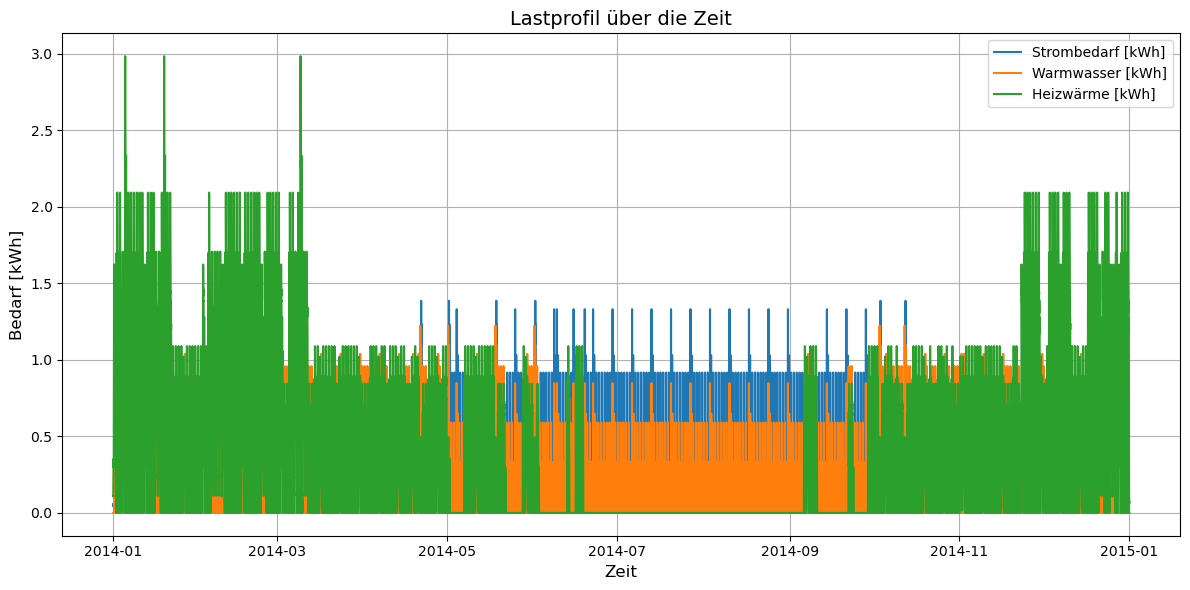

In [18]:
import matplotlib.pyplot as plt


# Plot erstellen
plt.figure(figsize=(12, 6))

# Einzelne Spalten plotten
plt.plot(lastprofil['Strombedarf [kWh]'], label='Strombedarf [kWh]')
plt.plot(lastprofil['Warmwasser [kWh]'], label='Warmwasser [kWh]')
plt.plot(lastprofil['Heizwärme [kWh]'], label='Heizwärme [kWh]')

# Diagramm anpassen
plt.title('Lastprofil über die Zeit', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


### WP UND SPEICHER DIMENSIONIERUNG NACH DIN 4645
1. Notwendige Heizleistung der WP
2. Wärmespeicher Dimensionierung - vereinfacht
3. Erforderliche Heizleistung der WP (WP Größe)

In [19]:
# Heizenergiebedarf
# Heizlast 
heizlast_j

# Sperrdauer pro Tag ist max. 2 Stunden & Leistungsdrosselung auf mind. 4,2 kW
sperrdauer = 0 # h -> 0 da Sperrdauer ist nur Leisrungdrosselung
d = 24 # Periode 24 h

# Energiemenge für die Raumheizung über 24 h
Q_heiz_tag = heizlast_j*d # kWh
Q_heiz_tag

216.0

In [20]:
# Q_twe_tag = tagesenergiebedarf.iloc[2].mean()
# print(Q_twe_tag)
# Q_twe_gesamt = lastprofil['Warmwasser [kWh]'].mean()
# Q_twe_gesamt

In [21]:
#  Bestimmung des Speichervolumens nach DIN 4645: K2.1.1 direkte Speicherung von erwärmtem Trinkwasser
# # Trinkwarmwasserbedarf
# # Zapf Profil aus Tabelle J3 (DIN 4645) ausgewählt: 3 Familienmitglieder inkl. Baden & Düschen
# # Die Bezugsperiode, die den größten Energiebedarf aufweist, ist der Zeitraum von 20:30 Uhr bis 21:30 Uhr.  
# # In diesem Zeitraum werden für jede Wohneinheit 2,24 kWh für die Trinkwassererwärmung benötigt.

# Q_twe_beszugsperiode = 2.24 # kWh

# # Über den gesamten Tag sind 5,845 kWh notwendig.
# Q_twe_tag = 5.845 # kWh

# # Oder aus berechnete TWE 
# Q_twe_tag = tagesenergiebedarf.iloc[2].mean()

# # TWE Speichervolumen
# T_frischwasser = 10 # Annahme Frischwasser Temperatur 
# c_wasser = 1.163 # Wh/LK - spezifische Wärmekapazität
# T_speicher_soll = 60 # °C

# # Speichervolumen für Bezugsperiode
# V_twe_bezugsperiode = Q_twe_beszugsperiode*1000/(c_wasser*(T_speicher_soll-T_frischwasser)) # l

# # Aufschlag für die Annahme von Durchmischungsverlusten bei der Speicherung des Trinkwassers 
# # mit f_twe = 1,15 für 15 %  Durchmischungsverlust bei der Speicherung des Trinkwassers 
# # und f_twe = 1,20 für 15 % Durchmischungsverlusten und 5 % Aufschlag für die Wärmeübertragung bei der Speicherung des Heizwassers
# f_twe = 1.2#

# # erforderliches Speichervolumen
# V_twe_min = V_twe_bezugsperiode*f_twe
# round(V_twe_min) ## 46 l

In [22]:
# Wahl der WP
Q_heiz_tag
# Q_twe_tag
d
sperrdauer

# erforderliche Wärmepumpenleistung in kW
Q_punkt_wp_min = (Q_heiz_tag)/(d-sperrdauer)
round(Q_punkt_wp_min)

9

In [23]:
# # Dimensionierung von Speichern zur Sicherstellung eines störungsfreien Betriebs

# # Mindestlaufzeit
# # Im ersten Fall soll der Speicher unabhängig von den Betriebsbedingungen der Heizungsanlage 
# # sowohl die erforderliche Mindestlaufzeit sicherstellen als auch die benötigte Energie zur Abtauung der Wärmepumpe mit Kreislaufumkehr bereitstellen.

# mindestlaufzeit = 3/60 # h -  Kompressormindestlaufzeit bei Vaillant Wärmepumpen https://www.vaillant.ch/downloads/planungsinformationen/berechnungsbeispiel-planungsmodul-waermepumpen-1782511.pdf
# T_delta = 5 # zulässige Temperaturerhöhung - für Auslegungsvorlauftemperaturen von 55°C zulässige Temperaturerhöhung von 5  K 
# ## 20 K für Auslegungsvorlauftemperaturen von 35 °C 
# dichte = 1 # kg/l 
# V_mindestlaufzeit = Q_punkt_wp_min*1000*mindestlaufzeit/(dichte*c_wasser*T_delta)

# # Abtauung
# t_abtauung = 10/60 # h
# COP_abtauung = 5
# T_delta_abtauung = 55-20
# V_abtauung = Q_punkt_wp_min*1000*t_abtauung*(COP_abtauung-1)/(dichte*c_wasser*T_delta_abtauung*COP_abtauung)
# V_abtauung

# V_sp_min = V_mindestlaufzeit+V_abtauung
# V_sp_min ##118,9 l

In [24]:
# Speichervolumen - Verenfachte Methode
# 20 l/kW Leistung in Auslegungspunkt

V_sp_einfach = 20 * heizlast_j # l
V_sp_einfach

180.0

In [25]:
# Ergebnisse
print(f"Ergebnisse für den PLZ '{plz}' in der TRY Region '{TRY_region}' & Baujahr '{baujahr}'")
print(' - Heizlast: ', heizlast_j, ' kW')
print(' - Heizbedarf für 1 Tag: ', Q_heiz_tag, ' kWh')
# print(' - Warmwasserwärmebedarf für 1 Tag: ', Q_twe_tag, 'kWh')
print(' - WP mindest Größe:', round(Q_punkt_wp_min),' kW')
print(' - Pufferspeichergröße min: ', round(V_sp_einfach), 'l')


Ergebnisse für den PLZ '40599' in der TRY Region '5' & Baujahr 'Nach 2002'
 - Heizlast:  9.0  kW
 - Heizbedarf für 1 Tag:  216.0  kWh
 - WP mindest Größe: 9  kW
 - Pufferspeichergröße min:  180 l


### WP Leistung und Speicher Ladezustand

1. Heizleistung pro Stunde berechnen
2. Pufferspeicher berücksichtigen 

In [26]:
# Heizleistung aus Heizwärmebedarf

# Resample pro Stunde 
lastprofil_h = lastprofil.resample('1h').sum()
lastprofil_h

,Strombedarf [kWh],Warmwasser [kWh],Heizwärme [kWh]
Zeit,,,
2014-01-01 00:00:00,0.209688,0.000000,0.518056
2014-01-01 01:00:00,0.199006,0.000000,0.823876
2014-01-01 02:00:00,0.212510,0.000000,1.116919
2014-01-01 03:00:00,0.209700,0.000000,1.359407
2014-01-01 04:00:00,0.205412,0.000000,1.280667
...,...,...,...
2014-12-31 19:00:00,0.744177,0.041829,4.807082
2014-12-31 20:00:00,0.721275,0.000000,3.853547
2014-12-31 21:00:00,0.695183,0.000000,1.934805


In [27]:
lastprofil_h[0:23].sum()

Strombedarf [kWh]    16.933205
Warmwasser [kWh]      5.230000
Heizwärme [kWh]      81.545177
dtype: float64

In [28]:
lastprofil_d = lastprofil.resample('24h').sum()
lastprofil_d

,Strombedarf [kWh],Warmwasser [kWh],Heizwärme [kWh]
Zeit,,,
2014-01-01,17.15,5.23,82.12
2014-01-02,14.76,4.57,90.24
2014-01-03,14.76,4.57,90.24
2014-01-04,13.80,4.16,91.85
2014-01-05,16.65,5.00,93.74
...,...,...,...
2014-12-27,14.76,4.57,90.24
2014-12-28,17.15,5.23,82.12
2014-12-29,14.76,4.57,90.24


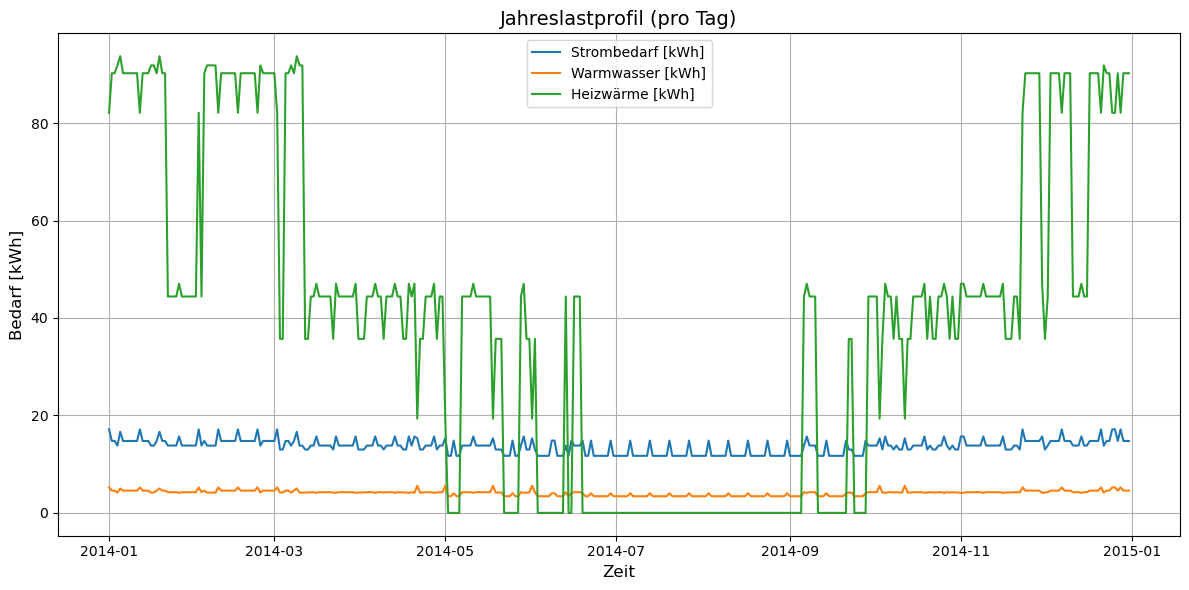

In [29]:
import matplotlib.pyplot as plt
# Plot erstellen
plt.figure(figsize=(12, 6))

# Einzelne Spalten plotten
plt.plot(lastprofil_d['Strombedarf [kWh]'], label='Strombedarf [kWh]')
plt.plot(lastprofil_d['Warmwasser [kWh]'], label='Warmwasser [kWh]')
plt.plot(lastprofil_d['Heizwärme [kWh]'], label='Heizwärme [kWh]')

# Diagramm anpassen
plt.title('Jahreslastprofil (pro Tag)', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

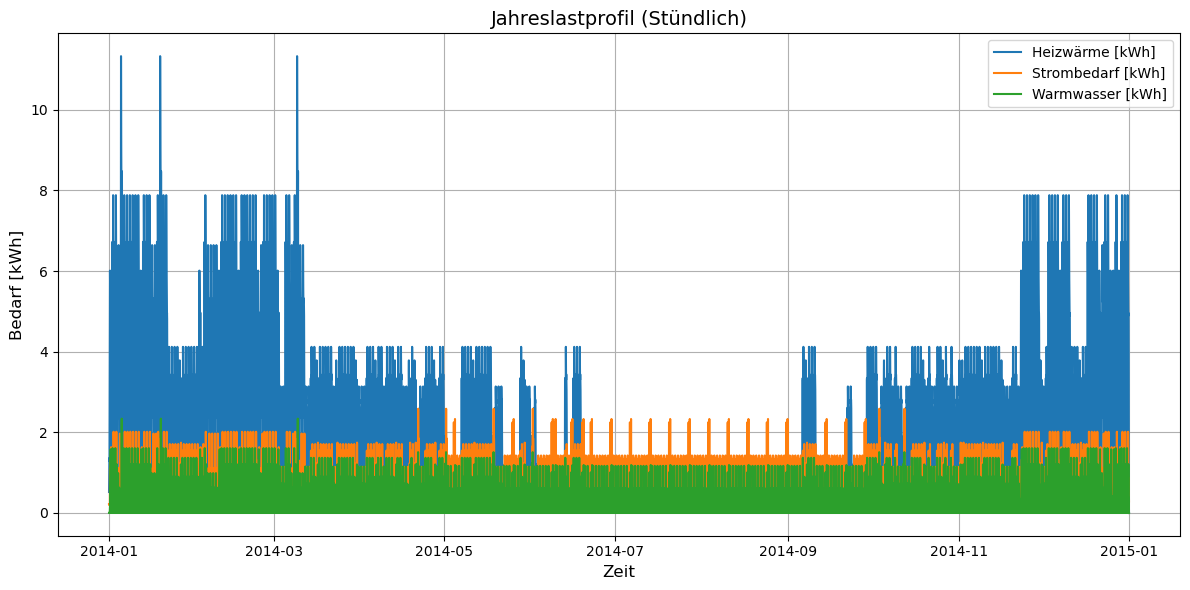

In [30]:
import matplotlib.pyplot as plt
# Plot erstellen
plt.figure(figsize=(12, 6))

# Einzelne Spalten plotten
plt.plot(lastprofil_h['Heizwärme [kWh]'], label='Heizwärme [kWh]')
plt.plot(lastprofil_h['Strombedarf [kWh]'], label='Strombedarf [kWh]')
plt.plot(lastprofil_h['Warmwasser [kWh]'], label='Warmwasser [kWh]')

# Diagramm anpassen
plt.title('Jahreslastprofil (Stündlich)', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [84]:
csv_tamb = 'C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\T_amb_40599_2014.csv'
t_amb = pd.read_csv(csv_tamb)
t_amb.set_index('time', inplace=True)
t_amb 

,temp
time,
2014-01-01 00:00:00,6.3
2014-01-01 01:00:00,5.0
2014-01-01 02:00:00,5.1
2014-01-01 03:00:00,5.5
2014-01-01 04:00:00,5.7
...,...
2014-12-31 19:00:00,1.9
2014-12-31 20:00:00,1.4
2014-12-31 21:00:00,1.1


In [32]:
# COP Berechnen

# COP ablesen
# excel_wp = 'C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\Inputs\\Vaillant_aroTHERM plus_3.5-12.5 kW.xlsx'
# wp_inputs = pd.read_excel(excel_wp)

# wp_inputs

### Heizkurve, Interpolation COP & P_el

In [85]:
# HEIZKURVE 

import matplotlib.pyplot as plt
import numpy as np

# T_aussen + Datum
heizkennlinie = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\Desktop\\Thesis\\T_amb_40599_2016.csv')

if baujahr == ('ab 2009', 'KfW 85', 'KfW 70', 'KfW 55', 'KfW 40','Passivhaus'):
    art = 'Fußbodenheizung'
    T_n_vor = 35
    T_n_rueck = 28
    T_soll = 20
    p = 1.1
    T_m_n_ueber = (T_n_vor-T_n_rueck)/(np.log((T_n_vor-T_soll)/(T_n_rueck-T_soll)))
else:
    art = 'Heizkörper'
    T_n_vor = 55
    T_n_rueck = 45
    T_soll = 20
    p = 1.3
    T_m_n_ueber = (T_n_vor-T_n_rueck)/(np.log((T_n_vor-T_soll)/(T_n_rueck-T_soll)))


# Lastverhältnis phi
t_amb['Lastverhältnis'] = np.divide(T_soll-t_amb['temp'], T_soll-T_n_aussen)

#e^x
t_amb['e^x'] = np.exp(np.divide((t_amb['Lastverhältnis']**(p-1/p))*(T_n_vor-T_n_rueck), T_m_n_ueber))

# Vorlauftemperatur: T_vor [°C]
t_amb['T_vor'] = np.divide(t_amb['e^x']*((T_n_vor-T_n_rueck)*t_amb['Lastverhältnis']+T_soll)-T_soll, t_amb['e^x']-1)

# Rücklauftemperatur: T_rueck [°C]
t_amb['T_rueck'] = t_amb['T_vor']-t_amb['Lastverhältnis']*(T_n_vor-T_n_rueck)

t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck
time,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347
...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792


In [35]:
# COP INTERPOLATION

# Nibe F2040 -> Teschnische Daten https://assetstore.nibe.se/hcms/v2.3/entity/document/24898/storage/MDI0ODk4LzAvbWFzdGVy
# COP bei Verschiedene Vorlauftemperaturen S. 67-68
# Nominelle Heizleistung bei europäisches Durchnittsklima S. 70

# COP Dictionary für Nibe F2024 6 bis 16
COP_6 = pd.DataFrame({'35':[1.5, 2.3, 2.5, 2.6, 2.6, 3.3, 3.6], 
                    '45':[1.6, 1.8, 2, 2.2, 2.3, 2.9, 3.3], 
                    '55':[1.4, 1.6, 1.7, 1.9, 2.1, 2.5, 2.7]},
                    index = ['-20', '-15', '-10', '-5', '0', '5', '7'])
COP_6.index.name = 'T_aussenluft'

COP_8 = pd.DataFrame({'35':[2, 2.2, 2.5, 2.7, 3.4, 4, 4.6], 
                    '45':[1.5, 1.7, 2, 2.2, 2.8, 3.3, 3.8], 
                    '55':[1.7, 1.8, 2, 2, 2.1, 2.5, 3]}, 
                    index = ['-20', '-15', '-10', '-5', '0', '5', '9'])
COP_8.index.name = 'T_aussenluft'

COP_12 = pd.DataFrame({'35':[2, 2.2, 2.5, 2.9, 3.5, 4.1, 4.9], 
                    '45':[1.5, 1.8, 2, 2.3, 2.9, 3.4, 3.9], 
                    '55':[1.9, 2, 2, 2, 2.1, 2.5, 3.1]}, 
                    index = ['-20', '-15', '-10', '-5', '0', '5', '9'])
COP_12.index.name = 'T_aussenluft'


COP_16 = pd.DataFrame({'35':[2, 2.2, 2.5, 2.9, 3.5, 4.2, 4.9], 
                    '45':[1.6, 1.8, 2, 2.3, 2.9, 3.5, 3.9], 
                    '55':[1.8, 1.9, 2.1, 2, 2.2, 2.7, 3.1]}, 
                    index = ['-20', '-15', '-10', '-5', '0', '5', '9'])
COP_16.index.name = 'T_aussenluft'

COP = {
    'Nibe F2040-6': COP_6, # Heizleistung 35/55: 5/5
    'Nibe F2040-8': COP_8, # Heizleistung 35/55: 8/7
    'Nibe F2040-12': COP_12, # Heizleistung 35/55: 12/10
    'Nibe F2040-16': COP_16, # Heizleistung 35/55: 15/14
}

COP['Nibe F2040-12']


,35,45,55
T_aussenluft,,,
-20,2.0,1.5,1.9
-15,2.2,1.8,2.0
-10,2.5,2.0,2.0
-5,2.9,2.3,2.0
0,3.5,2.9,2.1
5,4.1,3.4,2.5
9,4.9,3.9,3.1


In [36]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def bilinear_interpolate(df):
    # Erstellen einer erweiterten Temperaturreihe
    extended_x = np.arange(-20, 7.5, 0.5)  # Außentemperaturen von -20 bis 15 in Schritten von 0.5
    extended_y = np.arange(35, 55.5, 0.5)    # Wassertemperaturen von 35 bis 55 in Schritten von 0.5
    
    # Extrahieren der bekannten Außentemperaturen (Index) und Wassertemperaturen (Spaltennamen)
    x = df.index.astype(float)  # Außentemperaturen (Index)
    y = df.columns.astype(float)  # Wassertemperaturen (Spalten)

    # Erstellen einer bilinearen Interpolationsfunktion mit RegularGridInterpolator
    interpolator = RegularGridInterpolator((x, y), df.values, method='linear', fill_value=None)

    # Erstellen eines neuen DataFrames mit den erweiterten Temperaturwerten
    extended_df = pd.DataFrame(index=extended_x, columns=extended_y)

    # Interpolierte Werte berechnen und in das DataFrame einfügen
    for i, xi in enumerate(extended_x):
        for j, yi in enumerate(extended_y):
            # Überprüfen, ob der Wert innerhalb des gültigen Bereichs liegt
            # Sicherstellen, dass wir nur Werte innerhalb des ursprünglichen Datenbereichs verwenden
            xi_clipped = np.clip(xi, min(x), max(x))  # Begrenzen der Außentemperatur im Bereich von x
            yi_clipped = np.clip(yi, min(y), max(y))  # Begrenzen der Wassertemperatur im Bereich von y
            
            # Berechnung der interpolierten Werte
            extended_df.iloc[i, j] = interpolator((xi_clipped, yi_clipped)).round(2)  # Interpolation durchführen

    return extended_df

# Anwenden der Interpolation auf den COP_6 DataFrame
interpolated_df = bilinear_interpolate(COP_6)

# Ausgabe des interpolierten DataFrames
# print("Interpolierter DataFrame mit erweiterten Werten:")
# print(interpolated_df)

In [37]:
interpolated_df # Interpolierte Tabelle COP - T_wasser & T_aussen

,35.0,35.5,36.0,36.5,37.0,37.5,38.0,38.5,39.0,39.5,...,50.5,51.0,51.5,52.0,52.5,53.0,53.5,54.0,54.5,55.0
-20.0,1.5,1.5,1.51,1.52,1.52,1.52,1.53,1.54,1.54,1.55,...,1.49,1.48,1.47,1.46,1.45,1.44,1.43,1.42,1.41,1.4
-19.5,1.58,1.58,1.58,1.59,1.59,1.59,1.59,1.59,1.6,1.6,...,1.51,1.5,1.49,1.48,1.47,1.46,1.45,1.44,1.43,1.42
-19.0,1.66,1.66,1.66,1.66,1.66,1.66,1.65,1.65,1.65,1.65,...,1.53,1.52,1.51,1.5,1.49,1.48,1.47,1.46,1.45,1.44
-18.5,1.74,1.74,1.73,1.73,1.72,1.72,1.72,1.71,1.71,1.7,...,1.55,1.54,1.53,1.52,1.51,1.5,1.49,1.48,1.47,1.46
-18.0,1.82,1.81,1.81,1.8,1.79,1.78,1.78,1.77,1.76,1.76,...,1.57,1.56,1.55,1.54,1.53,1.52,1.51,1.5,1.49,1.48
-17.5,1.9,1.89,1.88,1.87,1.86,1.85,1.84,1.83,1.82,1.81,...,1.59,1.58,1.57,1.56,1.55,1.54,1.53,1.52,1.51,1.5
-17.0,1.98,1.97,1.95,1.94,1.93,1.92,1.9,1.89,1.88,1.86,...,1.61,1.6,1.59,1.58,1.57,1.56,1.55,1.54,1.53,1.52
-16.5,2.06,2.04,2.03,2.01,2.0,1.98,1.96,1.95,1.93,1.92,...,1.63,1.62,1.61,1.6,1.59,1.58,1.57,1.56,1.55,1.54
-16.0,2.14,2.12,2.1,2.08,2.06,2.04,2.03,2.01,1.99,1.97,...,1.65,1.64,1.63,1.62,1.61,1.6,1.59,1.58,1.57,1.56
-15.5,2.22,2.2,2.18,2.15,2.13,2.11,2.09,2.07,2.04,2.02,...,1.67,1.66,1.65,1.64,1.63,1.62,1.61,1.6,1.59,1.58


In [86]:
# COP zuweisen - T_amb und T_vorlauf

# Initialize the result list for COPs
t_amb['COP'] = None

# Iterate over rows in t_amb to find the closest COP for each row
for i, row in t_amb.iterrows():
    temp = row['temp']
    T_vor = row['T_vor']
    
    # Initialize variables to find the closest point
    naechster_cop = None
    kleinster_abstand = float('inf')  # Start with an infinitely large distance
    
    # Iterate over interpolated_df index (ambient temp) and columns (water temp)
    for x in interpolated_df.index:
        for y in interpolated_df.columns:
            abstand = abs(x - temp) + abs(y - T_vor)  # Combined distance
            
            # Update if the current distance is the smallest
            if abstand < kleinster_abstand:
                kleinster_abstand = abstand
                naechster_cop = interpolated_df.loc[x, y]
    
    # Assign the closest COP value to the current row
    t_amb.at[i, 'COP'] = naechster_cop

t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP
time,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02
...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.4
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,2.34


In [87]:
# filename = f'WP_40599_2014.csv'  # Generiere den Dateinamen basierend auf dem Schlüssel
# t_amb.to_csv(filename, index=True)  # Speichern in einer CSV-Datei


In [118]:
# P_el = P_th / COP
# das ist falsch - sollen heizwärme auslegung benutzen <- heizlast der Stunde 
# t_amb['P_th'] = lastprofil_h['Heizwärme [kWh]']
# t_amb['P_el'] = t_amb['P_th']/t_amb['COP']
t_amb['Heizwärme Theoretisch'] = t_amb['Lastverhältnis']*heizlast_j
t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizwärme Theoretisch
time,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,4.435252
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9,4.856115
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9,4.823741
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02,4.694245
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02,4.629496
...,...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47,5.859712
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.4,6.021583
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,2.34,6.118705


In [120]:
# import matplotlib.pyplot as plt

# t_amb.index = pd.to_datetime(t_amb.index)
# p_resampled = t_amb['P_el'].resample('D').sum()
# p_resampled.plot()

In [98]:
t_amb['P_el'].sum()

4382.930744803459

In [39]:
# Heizwärme Auslegung - Kennlinie 
# T_aussen -> von T_norm_aussen bis T_max (15°C)
# Norm Heizbedarf verteilt 

import pandas as pd
import numpy as np

# Beispielwerte
end_temp = 15  # Endwert der Temperatur
step = 0.1  # Schrittweite

# Index erstellen
index = np.arange(T_n_aussen, end_temp + step, step)

# Heizwärme Auslegung berechnen
length = len(index)
heizwaerme_auslegung = Q_punkt_wp_min - (np.arange(length) / (length - 1)) * Q_punkt_wp_min
lastverhaeltnis = np.divide(T_soll-index, T_soll-T_n_aussen)
heizwaerme_theoretisch = lastverhaeltnis*Q_punkt_wp_min

# DataFrame erstellen
auslegungs_heizleistung = pd.DataFrame({
    'T_aussen': index,
    'Lastverhältnis': lastverhaeltnis,
    'Heizwärme Auslegung': heizwaerme_auslegung,
    'Heizwärme Theoretisch': heizwaerme_theoretisch
}, index=index)

# Optional: T_aussen-Spalte entfernen, da diese im Index enthalten ist
# auslegungs_heizleistung.drop(columns='T_aussen', inplace=True)

auslegungs_heizleistung

,T_aussen,Lastverhältnis,Heizwärme Auslegung,Heizwärme Theoretisch
-7.8,-7.8,1.000000,9.000000,9.000000
-7.7,-7.7,0.996403,8.960526,8.967626
-7.6,-7.6,0.992806,8.921053,8.935252
-7.5,-7.5,0.989209,8.881579,8.902878
-7.4,-7.4,0.985612,8.842105,8.870504
...,...,...,...,...
14.6,14.6,0.194245,0.157895,1.748201
14.7,14.7,0.190647,0.118421,1.715827
14.8,14.8,0.187050,0.078947,1.683453
14.9,14.9,0.183453,0.039474,1.651079


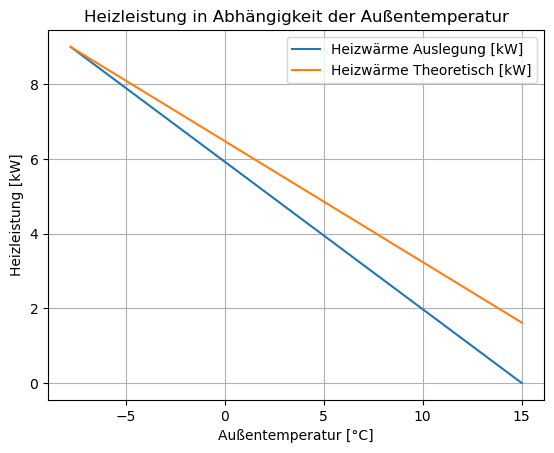

In [40]:
plt.plot(auslegungs_heizleistung['Heizwärme Auslegung'], label = 'Heizwärme Auslegung [kW]')
plt.plot(auslegungs_heizleistung['Heizwärme Theoretisch'], label = 'Heizwärme Theoretisch [kW]')

plt.xlabel('Außentemperatur [°C]')
plt.ylabel('Heizleistung [kW]')
plt.title('Heizleistung in Abhängigkeit der Außentemperatur')
plt.grid(True)
plt.legend()
plt.show()


In [88]:
# Initialize Heizleistung column
t_amb['Heizleistung'] = None

# Iterate over rows in t_amb to assign Heizleistung
for i, row in t_amb.iterrows():
    temp = row['temp']  # Wert der aktuellen Zeile aus t_amb
    
    # Initialize variables to find the closest temperature
    naechste_heizleistung = None
    kleinster_abstand = float('inf')  # Start with einer sehr großen Distanz
    
    # Iterate over auslegungs_heizleistung to find the closest match
    for j, aus_row in auslegungs_heizleistung.iterrows():
        T_aussen = aus_row['T_aussen']  # Temperatur aus auslegungs_heizleistung
        heizleistung = aus_row['Heizwärme Auslegung']  # Heizleistung
        
        # Berechne die Differenz (Abstand) zwischen den Temperaturen
        abstand = abs(T_aussen - temp)
        
        # Update, wenn die aktuelle Differenz kleiner ist
        if abstand < kleinster_abstand:
            kleinster_abstand = abstand
            naechste_heizleistung = heizleistung
    
    # Assign the closest Heizleistung to the current row
    t_amb.at[i, 'Heizleistung'] = naechste_heizleistung


In [89]:
#t_amb['elekt. Leistungaufnahme'] = t_amb['Heizleistung']/t_amb['COP']
#t_amb['therm. Entnahmelesitung'] = t_amb['Heizleistung'] - t_amb['elekt. Leistungaufnahme']
t_amb['Wärmebedarf'] = lastprofil_h['Heizwärme [kWh]']
t_amb


,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizleistung,Wärmebedarf
time,,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,3.434211,0.518056
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9,3.947368,0.823876
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9,3.907895,1.116919
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02,3.75,1.359407
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02,3.671053,1.280667
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47,5.171053,4.807082
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.4,5.368421,3.853547
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,2.34,5.486842,1.934805


In [90]:
#t_amb['elekt. Leistungaufnahme_LP'] = t_amb['Wärmebedarf Lastprofil']/t_amb['COP']
#t_amb['therm. Entnahmelesitung_LP'] = t_amb['Wärmebedarf Lastprofil'] - t_amb['elekt. Leistungaufnahme_LP']
#t_amb['Wärmebedarf Lastprofil'] = lastprofil_h['Heizwärme [kWh]']
filename = f'WP_40599_2014.csv'  # Generiere den Dateinamen basierend auf dem Schlüssel
t_amb.to_csv(filename, index=True)  # Speichern in einer CSV-Datei
t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizleistung,Wärmebedarf
time,,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,3.434211,0.518056
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9,3.947368,0.823876
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9,3.907895,1.116919
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02,3.75,1.359407
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02,3.671053,1.280667
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47,5.171053,4.807082
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.4,5.368421,3.853547
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,2.34,5.486842,1.934805


In [44]:
print('Heizwärmebedarf LP: ', t_amb['Wärmebedarf Lastprofil'].sum())
print('Heizwärmebedarf: ', t_amb['Heizleistung'].sum())
print('P_el LP: ', t_amb['elekt. Leistungaufnahme_LP'].sum())
print('P_el: ', t_amb['elekt. Leistungaufnahme'].sum())

# also beide Methoden möglich, keine große unterschied :o

Heizwärmebedarf LP:  14400.209999999941
Heizwärmebedarf:  14984.013157894758
P_el LP:  4382.930744803459
P_el:  5080.987951043868


In [10]:
# ohne Pufferspeicher - TRY 5 (Düsseldorf, EFH, 200 m2, HK, 3 Personen, Heizlast 9 kW)
stromverbrauch_wp = 5080.987 # kWh/a
stromkosten_wp = stromverbrauch_wp*0.358 # P_el [kWh/a] * Strompreis Dezember 24 Bestandkunden €/kWh
gasverbrauch = 140 * 200 # Durchschnittlich 140 kWh/m2a (ohne Warmwasser) https://www.entega.de/blog/gasverbrauch-berechnen/#:~:text=GASVERBRAUCH%20BERECHNEN%20ANHAND%20DER%20WOHNFL%C3%84CHE.&text=Als%20Durchschnittswert%20f%C3%BCr%20den%20Jahresverbrauch,140%20%3D%20ungef%C3%A4hrer%20Jahresverbrauch.
kosten_gas = gasverbrauch*0.1187 # Durchschnitt DE 2024 https://www.destatis.de/DE/Themen/Wirtschaft/Preise/Erdgas-Strom-DurchschnittsPreise/_inhalt.html
print('Stromverbrauch WP [kWh/a]: ', round(stromverbrauch_wp, 2))
print('Stromkosten WP [€/a]:', round(stromkosten_wp, 2) )
print('Gasverbrauch [kWh/a]:', round(gasverbrauch, 2) )
print('Gaskosten [€/a]:', round(kosten_gas, 2) )

Stromverbrauch WP [kWh/a]:  5080.99
Stromkosten WP [€/a]: 1818.99
Gasverbrauch [kWh/a]: 28000
Gaskosten [€/a]: 3323.6


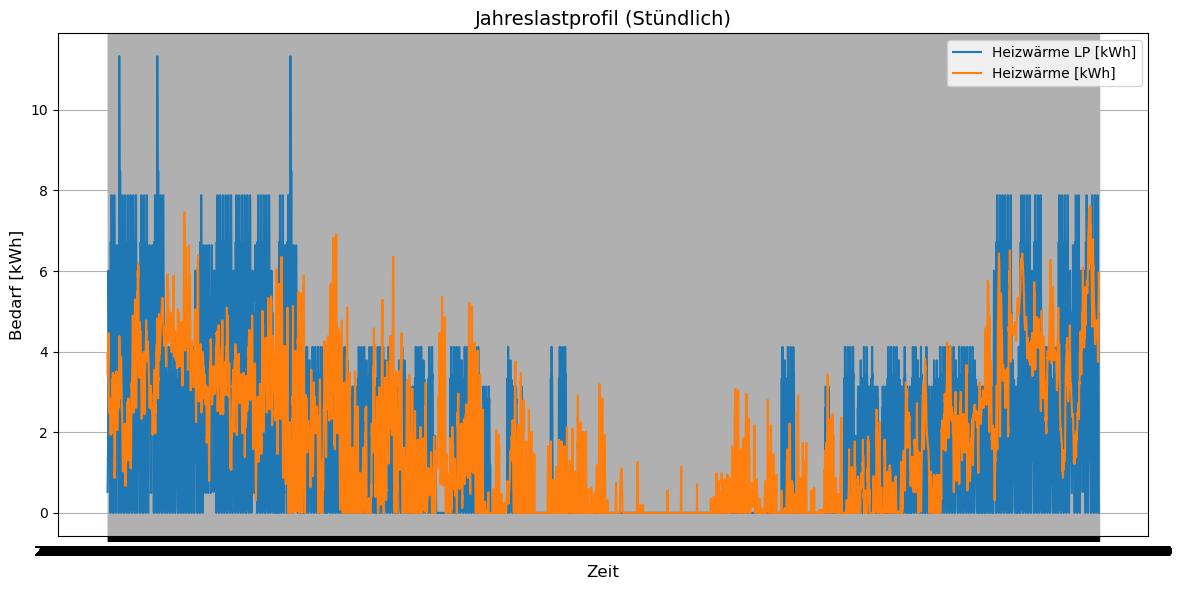

In [58]:
import matplotlib.pyplot as plt
# Plot erstellen
plt.figure(figsize=(12, 6))

# Einzelne Spalten plotten
plt.plot(t_amb['Wärmebedarf Lastprofil'], label='Heizwärme LP [kWh]')
plt.plot(t_amb['Heizleistung'], label='Heizwärme [kWh]')

# Diagramm anpassen
plt.title('Jahreslastprofil (Stündlich)', fontsize=14)
plt.xlabel('Zeit', fontsize=12)
plt.ylabel('Bedarf [kWh]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Diagramm anzeigen
plt.show()

### PS auswählen und anbinden

In [55]:
# Pufferspeicher auswählen 
# Vaillant https://www.vaillant.de/heizung/produkte/pufferspeicher-359745.html#specification
# VPS R 100/1 M - Bereitschaftswärmeverlust Speicher: 0,81 kWh/24h
# VPS R 200/1 B - Bereitschaftswärmeverlust Speicher: 1,4 kWh/24h
# VIH RW 300 - Bereitschaftswärmeverlust Speicher: 1,52 kWh/24
# TWL Pufferspeicher PR 500 Liter - Bereitschaftswärmeverlust Speicher: 1,4 kWh/24h -- https://www.solardirekt24.de/TWL-Pufferspeicher-PR-500-Liter-OEkoLine-A-Isolierung-PR.0500.Iso-A
VPS_100 = 100
VPS_200 = 200
VIH_300 = 300
TWL_PR_500 = 500

V_sp_einfach = 20*9

if V_sp_einfach > VPS_200:
    if V_sp_einfach <= VIH_300:
        V_ps = VIH_300
        V_verlust = 1.52 # kWh/24h
    else:
        V_ps = TWL_PR_500
        V_verlust = 1.4 # kWh/24h
elif V_sp_einfach <= VPS_200:
    if V_sp_einfach <= VPS_100:
        V_ps = VPS_100
        V_verlust = 0.81 # kWh/24h
    else:
        V_ps= VPS_200
        V_verlust = 1.4 # kWh/24h

V_ps

200

In [57]:
# Wärmegehalt Pufferspeicher
dichte = 1 # kg/m^3
c_wasser = 4.18 # kJ/(kg·K)
Q_ps = round(V_ps*dichte*c_wasser*(T_n_vor - T_n_rueck)/3600, 3)
Q_ps # kWh

2.322

In [ ]:
# Ladezustand, Wärmegehalt, Anbindung PS und WP
Ladezusatand_PS = 1
Waermegehalt_PS = Q_ps

t_amb.drop(columns=['elekt. Leistungaufnahme','therm. Entnahmelesitung','elekt. Leistungaufnahme_LP','therm. Entnahmelesitung_LP'], inplace=True)
t_amb


,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizleistung,Wärmebedarf Lastprofil
time,,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,3.434211,0.518056
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9,3.947368,0.823876
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9,3.907895,1.116919
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02,3.75,1.359407
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02,3.671053,1.280667
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,1.9,0.651079,1.307264,47.700356,41.189565,2.47,5.171053,4.807082
2014-12-31 20:00:00,1.4,0.669065,1.312377,48.109164,41.418517,2.4,5.368421,3.853547
2014-12-31 21:00:00,1.1,0.679856,1.315423,48.352353,41.553792,2.34,5.486842,1.934805


In [80]:
t_amb.drop(columns=['Wärmegehalt PS','Ladezustand PS','Heizleistung neu'], inplace=True)
t_amb.index = pd.to_datetime(t_amb.index)
t_amb['Wärmegehalt PS'] = None
t_amb['Ladezustand PS'] = None
t_amb['Heizleistung neu'] = None

# Manually initialize the first row (Index 0)
t_amb.loc[0, 'Wärmegehalt PS'] = Q_ps  # Initial value for Wärmegehalt PS (max value)
t_amb.loc[0, 'Ladezustand PS'] = 1  # Initial value for Ladezustand PS (fully loaded)
t_amb.loc[0, 'Heizleistung neu'] = t_amb.loc[0, 'Heizleistung']  # Initial value for Heizleistung neu

# Ensure 'Wärmebedarf Lastprofil' doesn't contain NaN values
t_amb['Wärmebedarf Lastprofil'] = t_amb['Wärmebedarf Lastprofil'].fillna(0)

t_amb

,temp,Lastverhältnis,e^x,T_vor,T_rueck,COP,Heizleistung,Wärmebedarf Lastprofil,Wärmegehalt PS,Ladezustand PS,Heizleistung neu
time,,,,,,,,,,,
2014-01-01 00:00:00,6.3,0.492806,1.260006,43.881684,38.953627,3.23,3.434211,0.518056,None,None,None
2014-01-01 01:00:00,5.0,0.539568,1.274443,45.056198,39.660515,2.9,3.947368,0.823876,None,None,None
2014-01-01 02:00:00,5.1,0.535971,1.273348,44.967379,39.607667,2.9,3.907895,1.116919,None,None,None
2014-01-01 03:00:00,5.5,0.521583,1.268943,44.609629,39.393802,3.02,3.75,1.359407,None,None,None
2014-01-01 04:00:00,5.7,0.514388,1.266725,44.429232,39.285347,3.02,3.671053,1.280667,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,None,None,None
1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,None,None,None
1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,None,None,None


In [75]:
t_amb.index = pd.to_datetime(t_amb.index)
t_amb['Wärmegehalt PS'] = None
t_amb['Ladezustand PS'] = None
t_amb['Heizleistung neu'] = None
t_amb.loc[0,'Wärmegehalt PS'] = Q_ps
t_amb.loc[0,'Ladezustand PS'] = 1
t_amb.loc[0,'Heizleistung neu'] =  t_amb.loc[0,'Heizleistung']
t_amb['Wärmebedarf Lastprofil'] = t_amb['Wärmebedarf Lastprofil'].fillna(0)

# Schleife über den Index des DataFrames (ab der ersten Zeile, Index 0)
for time in t_amb.index[1:]:
    # Berechnung der Heizleistung basierend auf dem Ladezustand und dem Wärmebedarf
    if time.month > 3 and time.month < 10:  # Zeit von April bis Oktober
        t_amb.loc[time, 'Heizleistung neu'] = 0
    elif t_amb.loc[time - pd.Timedelta(hours=1), 'Wärmegehalt PS'] > t_amb.loc[time, 'Wärmebedarf Lastprofil']:
        t_amb.loc[time, 'Heizleistung neu'] = 0
    elif t_amb.loc[time - pd.Timedelta(hours=1), 'Ladezustand PS'] < 0.5:
        if Q_ps - t_amb.loc[time - pd.Timedelta(hours=1), 'Wärmegehalt PS'] > t_amb.loc[time, 'Heizleistung']:
            t_amb.loc[time, 'Heizleistung neu'] = t_amb.loc[time, 'Heizleistung'] + Q_ps - t_amb.loc[time - pd.Timedelta(hours=1), 'Wärmegehalt PS']
        else:
            t_amb.loc[time, 'Heizleistung neu'] = t_amb.loc[time, 'Heizleistung']
    
    # Berechnungen für den Wärmegehalt und Ladezustand werden erst jetzt durchgeführt
    if time != t_amb.index[0]:  # Für alle Zeitstempel ab Index 1
        # Berechnung des neuen Wärmegehalts basierend auf dem Wert der vorherigen Stunde
        t_amb.loc[time, 'Wärmegehalt PS'] = t_amb.loc[time - pd.Timedelta(hours=1), 'Wärmegehalt PS'] - t_amb.loc[time, 'Wärmebedarf Lastprofil'] - V_verlust / 24 - t_amb.loc[time, 'Heizleistung neu']
    
    # Berechnung des Ladezustands
    t_amb.loc[time, 'Ladezustand PS'] = t_amb.loc[time, 'Wärmegehalt PS'] / Q_ps

t_amb


TypeError: '<' not supported between instances of 'float' and 'NoneType'

In [ ]:
# Ladezustand, Wärmegehalt, Anbindung PS und WP
t_amb['Wärmegehalt PS'] = None
t_amb['Ladezustand PS'] = None

if time>April and time<Oktober: # time ist der index z.B. 2014-12-31 23:00:00
    if t_amb['Wärmegehalt PS'] > t_amb['Wärmebedarf Lastprofil']:
        t_amb['Heizleistung neu'] = 0
    elif t_amb['Ladezustand PS'] < 0.5:
        if Q_ps-t_amb['Wärmegehalt PS'] > t_amb['Heizleistung']:
            t_amb['Heizleistung neu'] = t_amb['Heizleistung'] + Q_ps-t_amb['Wärmegehalt PS']
        else:
            t_amb['Heizleistung neu'] = t_amb['Heizleistung']
            
t_amb['Wärmegehalt PS'] = t_amb['Wärmegehalt PS'] - t_amb['Wärmebedarf Lastprofil'] - V_verlust/24 - t_amb['Heizleistung'] # Wärmegehalt für nächste Zeitpunkt
t_amb['Ladezustand PS'] = t_amb['Wärmegehalt PS']/Q_ps